In [1]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
points = np.random.rand(100, 2)

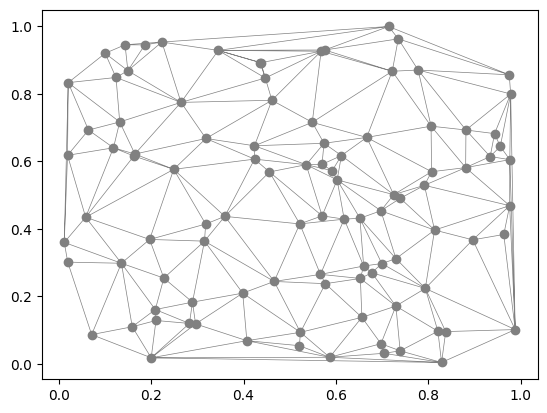

In [39]:
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)

Use Delaunay Triangulation to find neighbors with [vertex_neighbor_vertices](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.vertex_neighbor_vertices.html#scipy.spatial.Delaunay.vertex_neighbor_vertices)

In [6]:
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices

See the particle of interest and neighbors.

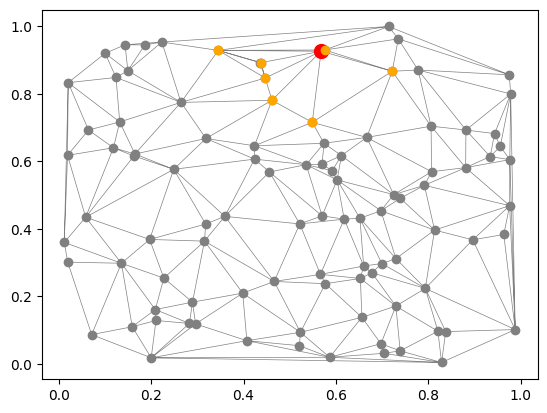

In [38]:
i = 6
neighbor_indices = indices[indptr[i]: indptr[i+1]]
plt.scatter(points[:, 0], points[:, 1], color="gray")
plt.triplot(points[:, 0], points[:, 1], color="gray", lw=0.5)
plt.scatter(points[i, 0], points[i, 1], color="red", s=100)
plt.scatter(points[neighbor_indices, 0], points[neighbor_indices, 1], color="orange")

Construct neighborlist as in Nathan's code: array of particle number list.

In [41]:
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]


Does it take too long for larger point sets?

In [45]:
points = np.random.rand(100000, 2)
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

For a 100,000-point set, it takes 0.6 s to construct the neighborlist. In the current application, typical number of particle is < 10,000 each frame, so the performance is not an issue.

## Affine field

We first use Nathan's code. Since the k-d tree method is integrated in the `packing._affine_field` method, we need to rewrite the method.

In [137]:
import philatracks
import scipy

In [154]:
class dt_NNEngine(philatracks.packing.NNEngine):
    def _affine_field(self, d2min_scale=1.0, dview=None, neighbor_method="kdtree"):
        # Highly-optimized affine field computation, using a direct line to FORTRAN (LAPACK).
        # The prototype for this design is the map() method.
        def worker(data, loopindices, coords, nncutoff):
            # This runs only once on each engine so it's ok to have all this setup code
            tree = scipy.spatial.cKDTree(coords, 5) # 5 levels in the tree. YMMV.
            # Laughing in the face of danger, we use the Fortran linear system solver directly.
            solver, = scipy.linalg.lapack.get_lapack_funcs(('gelss',), (data, data))
            results = np.ones((len(loopindices), 5)) * np.nan # 5 output columns
            if neighbor_method == "kdtree":
                neighborlist = tree.query_ball_point(coords[loopindices], nncutoff)
            elif neighbor_method == "delaunay":
                dt = Delaunay(coords[loopindices])
                indptr, indices = dt.vertex_neighbor_vertices
                neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]
            for i, (pindex, neighbors) in enumerate(zip(loopindices, neighborlist)):
                if neighbor_indices == "kdtree":
                    neighbors.remove(pindex)
                if len(neighbors) < 2: continue  # Minimum to satisfy DOF
                r = data[neighbors] - np.tile(data[pindex], (len(neighbors), 1))
                # The rest of the loop body is computation-specific.
                try:
                    solvret = solver(r[:,0:2], r[:,2:4]) # v, x, s, rank, work, info
                    assert solvret[5] == 0 # "info"
                except:
                    continue # Did not converge or not enough data; results will be NaN
                results[i,:4] = solvret[1][:2].flat
                # NORMALIZE by number of particles
                results[i,4] = (solvret[1][2:]**2).sum() / len(neighbors) 
                # Uncommenting the assert below checks that D2min is equal to the residual.
                #assert np.allclose(results[i,4], np.sum((r[:,0:2].dot(gelret[1][:2]) \
                        #- r[:,2:4])**2) / len(neighbors)) 
            return results
        alldata = self.frametracks[['x', 'y', 'x0', 'y0']].values
        allresults = np.ones((alldata.shape[0], 5)) * np.nan
        if dview is None:
            # Single-threaded
            allresults[self.loopindices] = worker(alldata, self.loopindices, self.coords, self.nncutoff)
        else: # IPython parallel computing
            from IPython.parallel.util import interactive
            dview.execute('''import scipy.linalg.lapack, scipy.spatial''')
            dview.execute('''import numpy as np''')
            # To send function to engines, its parent namespace must be the global namespace. 
            dview['worker'] = interactive(worker)
            dview['data'] = alldata
            # Each engine considers a different set of particles
            dview.scatter('loopindices', self.loopindices) 
            dview['coords'] = self.coords
            dview['nncutoff'] = self.nncutoff
            dview.execute('''results = worker(data, loopindices, coords, nncutoff)''')
            allresults[self.loopindices] = dview.gather('results', block=True)
        rtr = self.frametracks.copy()
        for i, name in enumerate(['xdil', 'vstrain', 'hstrain', 'ydil', 'd2min']):
            rtr[name] = allresults[:,i]
        # FURTHER NORMALIZE by interparticle distance, if provided.
        rtr['d2min'] = rtr.d2min / d2min_scale**2
        return rtr

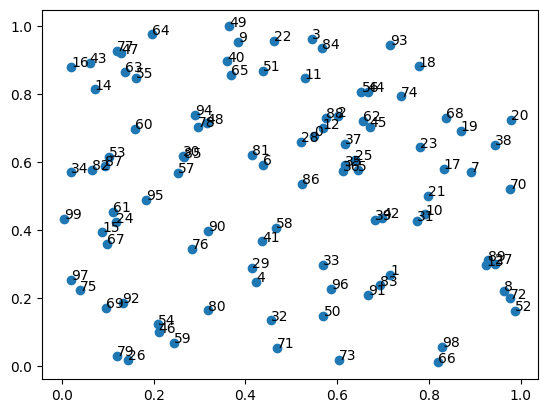

In [139]:
# simulate some artificial data, 
# where part of the particles translate and rotate for a small angle
# while all particles are subject to some noise
import pandas as pd

np.random.seed(0)
ftr0 = pd.DataFrame({"x": np.random.rand(100), "y": np.random.rand(100), 
                        "particle": np.arange(100), "frame": 0})
plt.scatter(ftr0.x, ftr0.y)
for num, i in ftr0.iterrows():
    plt.annotate(i.particle.astype("int"), (i.x, i.y), xycoords="data")

Select points (76, 90, 4, 29, 41, 58, 33) as the translation and rotation points.

In [140]:
poi = [76, 90, 4, 29, 41, 58, 33]
ftr1 = ftr0.copy()
# translate by 0.05
ftr1.loc[poi, "x"] += 0.02
# rotate about it's center of mass by 5 degrees
theta = np.radians(-15)
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array(((c, -s), (s, c)))
coords = ftr1.loc[poi, ["x", "y"]].values # N x 2
center_of_mass = coords.mean(axis=0)
coords_relative = coords - center_of_mass
coords_relative_rotated = np.matmul(rotation_matrix, coords_relative.T).T
coords_rotated = coords_relative_rotated + center_of_mass
ftr1.loc[poi, ["x", "y"]] = coords_rotated
# add a little bit noise to all points
ftr1["x"] += (np.random.rand(100) - 0.5) * 0.01
ftr1["y"] += (np.random.rand(100) - 0.5) * 0.01

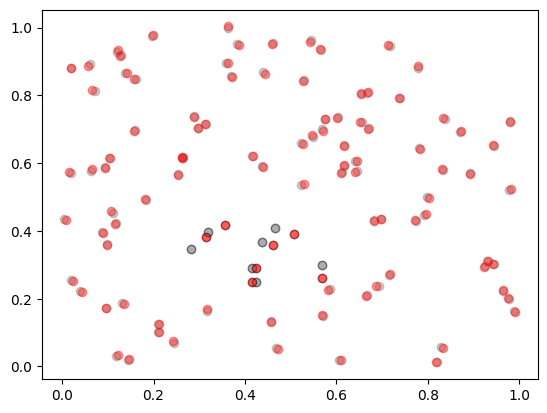

In [141]:
plt.scatter(ftr0.x, ftr0.y, color="gray", alpha=0.4)
plt.scatter(ftr1.x, ftr1.y, color="red", alpha=0.4)
plt.scatter(ftr0.loc[poi, "x"], ftr0.loc[poi, "y"], color="gray", alpha=0.4, ec="black")
plt.scatter(ftr1.loc[poi, "x"], ftr1.loc[poi, "y"], color="red", alpha=0.4, ec="black")
# plt.scatter(coords_rotated[:, 0], coords_rotated[:, 1], color="blue")

In [155]:
cutoff = 0.1
fast = False
subset = None
d2min_scale = 1.0
dview = None

ftrcomp = ftr1[['particle', 'x', 'y']].join(ftr0.set_index('particle')[['x', 'y']], 
                        on='particle', rsuffix='0').dropna()
NNE = dt_NNEngine(ftrcomp, cutoff, fast=fast, subset=subset)
results = NNE._affine_field(d2min_scale=d2min_scale, dview=dview, neighbor_method="delaunay")

C:\Users\liuzy\AppData\Local\Temp\ipykernel_24412\842204175.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if neighbor_indices == "kdtree":


In [157]:
results.dropna().head()

,particle,x,y,x0,y0,xdil,vstrain,hstrain,ydil,d2min
0,0,0.546931,0.681882,0.548814,0.677817,0.997702,-0.017226,0.003872,0.961494,0.000162
1,1,0.717153,0.272748,0.715189,0.270008,1.000745,-0.003594,-0.000605,1.003401,0.000018
2,2,0.601541,0.733525,0.602763,0.735194,0.997452,-0.000950,0.001158,1.001783,0.000010
4,4,0.415930,0.248814,0.423655,0.248753,0.987093,0.002482,-0.015624,1.006009,0.000401
5,5,0.641567,0.573480,0.645894,0.576157,1.008475,0.000136,-0.002704,1.001148,0.000039


k-d tree and delaunay, which is faster?

In [158]:
points = np.random.rand(100000, 2)

In [166]:
# k-d tree
tree = scipy.spatial.cKDTree(points, 5)
neighborlist = tree.query_ball_point(points, 0.01)

The efficiency of k-d tree depends a lot on the cutoff distance. When distance is too large, so that the number of neighbors is large, the efficiency gets low. For a reasonable cutoff, where each node has a few neighbors, it is not slow. 0.01 is one of such reasonable cutoffs, and it takes 3 seconds to construct a neighborlist for a point set of 100,000.

In [168]:
# delaunay
dt = Delaunay(points)
indptr, indices = dt.vertex_neighbor_vertices
neighborlist = [indices[indptr[i]: indptr[i+1]] for i in range(len(indptr)-1)]

For delaunay method, no cutoff is needed since the algorithm always only finds the nearest "enclosing" neighbors. Therefore, direct comparison is not possible. However, delaunay algorithm is comparable to k-d tree algorithm at the small cutoff limit.